# 1. Import dataset


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import *
from sklearn.ensemble import GradientBoostingRegressor
import tensorflow as tf
from keras.callbacks import *

data = pd.read_excel("Rental_Fully_Prepared_For_LSTM.xlsx")
# print(data.info())
# print(data.head())

# Train LSTM Model

Epoch 1/50
408/408 [==============================] - 27s 46ms/step - loss: 2.1701 - val_loss: 1.2474 - lr: 0.1000
Epoch 2/50
408/408 [==============================] - 19s 47ms/step - loss: 1.5586 - val_loss: 0.9519 - lr: 0.1000
Epoch 3/50
408/408 [==============================] - 21s 51ms/step - loss: 1.2830 - val_loss: 0.7529 - lr: 0.1000
Epoch 4/50
408/408 [==============================] - 18s 43ms/step - loss: 1.2687 - val_loss: 0.9893 - lr: 0.1000
Epoch 5/50
408/408 [==============================] - 20s 50ms/step - loss: 1.2101 - val_loss: 0.8154 - lr: 0.1000
Epoch 6/50
408/408 [==============================] - 18s 45ms/step - loss: 1.2488 - val_loss: 3.0206 - lr: 0.1000
Epoch 7/50
408/408 [==============================] - 17s 43ms/step - loss: 0.7834 - val_loss: 0.7518 - lr: 0.0100
Epoch 8/50
408/408 [==============================] - 18s 45ms/step - loss: 0.7162 - val_loss: 0.6906 - lr: 0.0100
Epoch 9/50
408/408 [==============================] - 19s 47ms/step - loss: 0.71

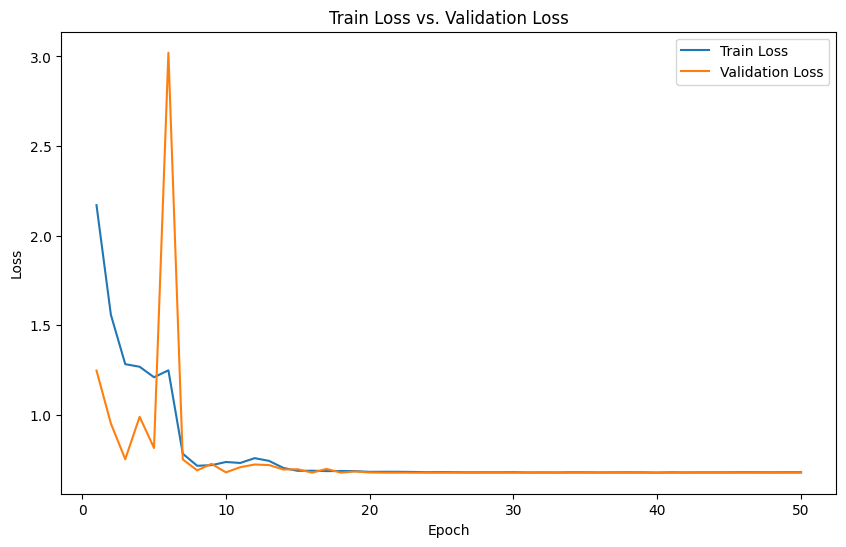

In [3]:
# Select the features for prediction
features = ['Area', 'Floor', 'Total_floor', 'Orientation', 'Longitude', 'Latitude', 'Elevators', 'Water', 'Electricity',\
            'Gas', 'Nearest subway distance', 'First area', 'Second area', 'Community name', 'Lease method',\
            'Room', 'Hall', 'Toilet', 'Availability', 'Showings time', 'Listing Year', 'Listing Month', 'Listing Day']

# Select the target variable
target = 'Price'

# Split the data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(data[features], np.log1p(data[target]), test_size=0.3, random_state=42)

# Reshape the features for LSTM input
train_data_reshaped = np.reshape(train_data.values, (train_data.shape[0], 1, train_data.shape[1]))
test_data_reshaped = np.reshape(test_data.values, (test_data.shape[0], 1, test_data.shape[1]))

# Build the LSTM model
model = Sequential()
dropout_rate = 0.5
num_units = 300
# model.add(Bidirectional(LSTM(16, return_sequences=True), input_shape=(1, len(features))))
# model.add(Activation('relu'))
# model.add(Bidirectional(LSTM(16)))
model.add(LSTM(num_units, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(LSTM(num_units, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(LSTM(num_units))
model.add(Dropout(dropout_rate))
model.add(Dense(1))

# Compile the model
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
optimizer = Adam(learning_rate=0.1)
model.compile(optimizer=optimizer, loss="mse")

# Train the model
history = model.fit(train_data_reshaped, train_labels, epochs=50, validation_data=(test_data_reshaped, test_labels), callbacks=[lr_scheduler])

# Evaluate the model
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Make predictions
epochs = np.arange(1, len(train_loss) + 1)

# plot train loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs. Validation Loss')
plt.legend()
plt.show()

# Evaluate the LSTM

175/175 [==============================] - 2s 9ms/step
MSE (tolerance=0.1): 0.677416997727659
Accuracy (tolerance=0.1): 0.6702489700877664
Average Error Rate: 0.08060676645748205
Average Accuracy: 0.9193932335425179
Train R-squared: -3.2178341777822084e-06
Test R-squared: -7.729730388650324e-06
Train RMLSE: 0.08633161759815354
Test RMLSE: 0.08624755016022477


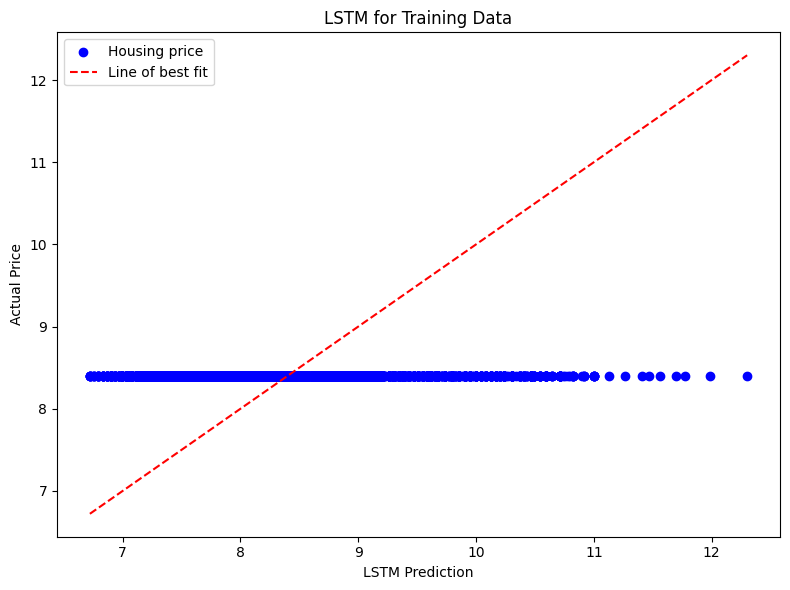

In [4]:
from sklearn.inspection import permutation_importance

def calculate_accuracy(predictions, labels, tolerance=0.1):
    total = len(labels)
    mse = np.mean((labels - predictions) ** 2)
    accuracy = np.mean(np.abs(predictions - labels) / labels <= tolerance)
    print(f"MSE (tolerance={tolerance}): {mse}")
    print(f"Accuracy (tolerance={tolerance}): {accuracy}")
    return mse, accuracy

def calculate_average_error(predictions, labels):
    errors = np.abs(predictions - labels)
    error_rate = np.mean(errors / labels)
    accuracy = 1 - error_rate
    print("Average Error Rate:", error_rate)
    print("Average Accuracy:", accuracy)

def rmlse(y_true, y_pred):
    y_true = np.log1p(y_true)
    y_pred = np.log1p(y_pred)
    squared_log_errors = np.square(y_pred - y_true)
    mean_squared_log_error = np.mean(squared_log_errors)
    rmlse = np.sqrt(mean_squared_log_error)
    return rmlse

# Make predictions
train_predictions = model.predict(train_data_reshaped)
test_predictions = model.predict(test_data_reshaped)

# Convert Series to NumPy arrays and reshape
test_predictions = np.array(test_predictions).reshape(-1)
test_labels = np.array(test_labels).reshape(-1)
train_labels = np.array(train_labels).reshape(-1)

# Calculate accuracy
calculate_accuracy(test_predictions, test_labels)
calculate_average_error(test_predictions, test_labels)
train_r2 = r2_score(train_labels, train_predictions)
test_r2 = r2_score(test_labels, test_predictions)
train_rmlse = rmlse(train_labels, train_predictions)
test_rmlse = rmlse(test_labels, test_predictions)

print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)
print("Train RMLSE:", train_rmlse)
print("Test RMLSE:", test_rmlse)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(test_labels, test_predictions, color='blue', label='Housing price')
ax.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'r--', label='Line of best fit')
ax.set_title('LSTM for Training Data')
ax.set_xlabel('LSTM Prediction')
ax.set_ylabel('Actual Price')
ax.legend()
plt.tight_layout()
plt.show()

# 2. Train Gradient Boosting model

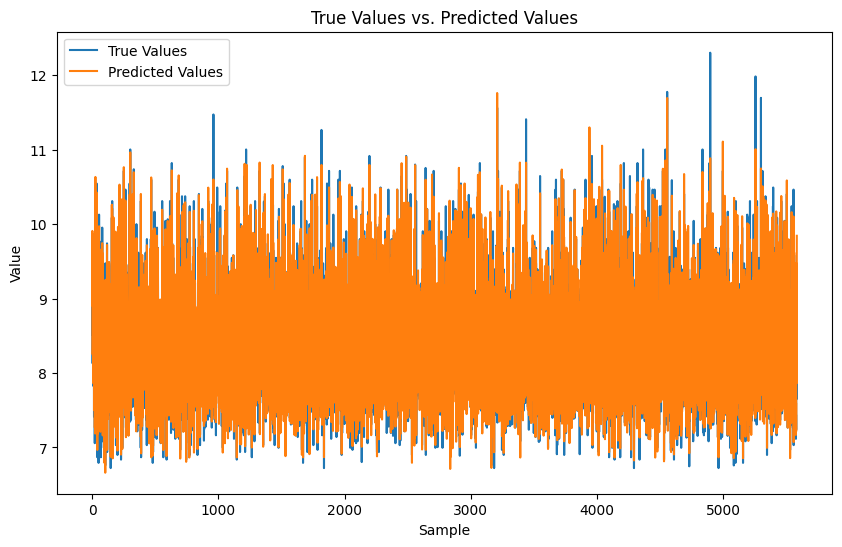

In [12]:
# Select the features for prediction
features = ['Area', 'Floor', 'Total_floor', 'Orientation', 'Longitude', 'Latitude', 'Elevators', 'Water', 'Electricity',\
            'Gas', 'Nearest subway distance', 'First area', 'Second area', 'Community name', 'Lease method',\
            'Room', 'Hall', 'Toilet', 'Availability', 'Showings time', 'Listing Year', 'Listing Month', 'Listing Day']

# Select the target variable
target = 'Price'

# Split the data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(data[features], np.log1p(data[target]), test_size=0.3, random_state=42)
# print(test_labels)

def rmlse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.sqrt(tf.reduce_mean(tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))))

# Build the model
model_gb = GradientBoostingRegressor(learning_rate=0.1, n_estimators=500, max_depth=5)

# Train the model
model_gb.fit(train_data, train_labels)

# Make predictions
train_predictions = model_gb.predict(train_data)
test_predictions = model_gb.predict(test_data)

# Plotting the true values and predicted values
plt.figure(figsize=(10, 6))
plt.plot(range(len(test_labels)), test_labels, label='True Values')
plt.plot(range(len(test_labels)), test_predictions, label='Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('True Values vs. Predicted Values')
plt.legend()
plt.show()

# 3. Evaluate the Gradient Boosting


MSE (tolerance=0.1): 0.032180881389320556
Accuracy (tolerance=0.1): 0.9948056600394053
Average Error Rate: 0.01354002801791585
Average Accuracy: 0.9864599719820841
Train R-squared: 0.9854296348446941
Test R-squared: 0.9524943568779549
Train RMLSE: 0.010587526057261936
Test RMLSE: 0.018707135532505706


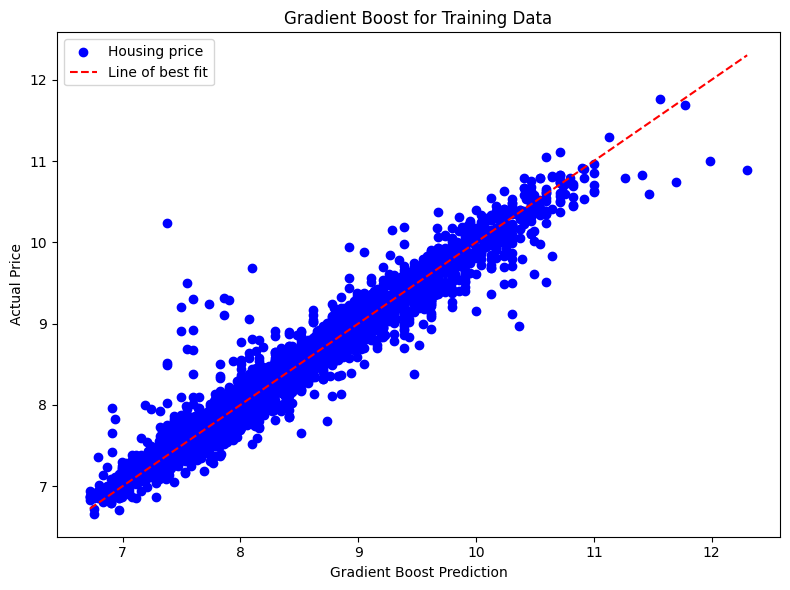


Feature Importance:
                    Feature  Importance
0                      Area    0.772754
5                  Latitude    0.147815
4                 Longitude    0.022345
2               Total_floor    0.013229
15                     Room    0.007694
17                   Toilet    0.006000
10  Nearest subway distance    0.004461
14             Lease method    0.004261
13           Community name    0.004091
12              Second area    0.003981
1                     Floor    0.002082
6                 Elevators    0.002037
21            Listing Month    0.001675
16                     Hall    0.001675
22              Listing Day    0.001508
11               First area    0.001270
3               Orientation    0.001019
20             Listing Year    0.000810
19            Showings time    0.000478
8               Electricity    0.000331
7                     Water    0.000164
9                       Gas    0.000163
18             Availability    0.000158


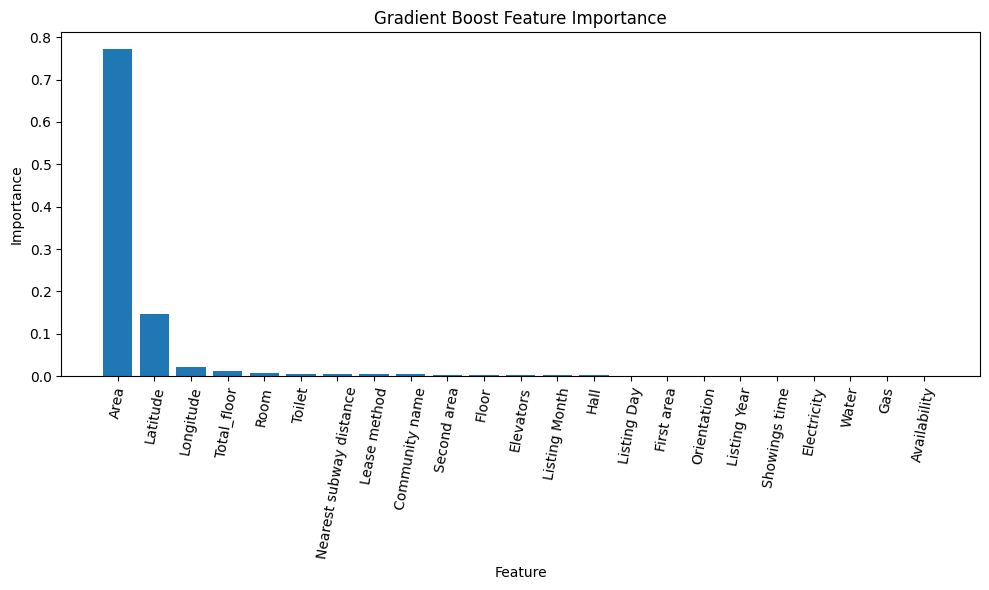

In [13]:
def calculate_accuracy(predictions, labels, tolerance=0.1):
    total = len(labels)
    mse = np.mean((labels - predictions) ** 2)
    accuracy = np.mean(np.abs(predictions - labels) / labels <= tolerance)
    print(f"MSE (tolerance={tolerance}): {mse}")
    print(f"Accuracy (tolerance={tolerance}): {accuracy}")
    return mse, accuracy

def calculate_average_error(predictions, labels):
    errors = np.abs(predictions - labels)
    error_rate = np.mean(errors / labels)
    accuracy = 1 - error_rate
    print("Average Error Rate:", error_rate)
    print("Average Accuracy:", accuracy)

def rmlse(y_true, y_pred):
    y_true = np.log1p(y_true)
    y_pred = np.log1p(y_pred)
    squared_log_errors = np.square(y_pred - y_true)
    mean_squared_log_error = np.mean(squared_log_errors)
    rmlse = np.sqrt(mean_squared_log_error)
    return rmlse

# Calculate accuracy
calculate_accuracy(test_predictions, test_labels)
calculate_average_error(test_predictions, test_labels)
train_r2 = r2_score(train_labels, train_predictions)
test_r2 = r2_score(test_labels, test_predictions)
train_rmlse = rmlse(train_labels, train_predictions)
test_rmlse = rmlse(test_labels, test_predictions)

print("Train R-squared:", train_r2)
print("Test R-squared:", test_r2)
print("Train RMLSE:", train_rmlse)
print("Test RMLSE:", test_rmlse)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(test_labels, test_predictions, color='blue', label='Housing price')
ax.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'r--', label='Line of best fit')
ax.set_title('Gradient Boost for Training Data')
ax.set_xlabel('Gradient Boost Prediction')
ax.set_ylabel('Actual Price')
ax.legend()
plt.tight_layout()
plt.show()

feature_importances = model_gb.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation=80)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Gradient Boost Feature Importance')
plt.tight_layout()
plt.show()
